In [ ]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

print("Working dir:", Path.cwd())

FEATURES_PATH = Path("data/processed/features.csv")
FIG_DIR = Path("reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

FEATURES_PATH, FIG_DIR


Working dir: c:\Users\15173\Desktop\stock-ts-forecast


(WindowsPath('data/processed/features.csv'), WindowsPath('reports/figures'))

In [11]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error
)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,4)

def cls_metrics(y_true, y_pred, y_proba=None):
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0)
    }
    if y_proba is not None:
        try:
            out["roc_auc"] = roc_auc_score(y_true, y_proba)
        except Exception:
            out["roc_auc"] = np.nan
    return out

def reg_metrics(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False)
    }

def plot_confmat(y_true, y_pred, title, path):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.show()

def plot_pred_vs_true(y_true, y_pred, title, path):
    fig, ax = plt.subplots()
    ax.plot(y_true, label="True")
    ax.plot(y_pred, label="Pred")
    ax.set_title(title); ax.legend()
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.show()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [12]:
df = pd.read_csv(FEATURES_PATH, index_col=0, parse_dates=True)
print(df.shape)
df.head()


(3483, 24)


,AAPL_log_ret,SPY_log_ret,VIX_level,VIX_change,sma_5,sma_10,sma_20,ema_12,ema_26,macd,...,stoch_d,roc_10,rollstd_10,rollstd_20,atr_14,bb_percentb,high_low_spread,volume_change,next_log_ret,next_ret_up
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.005360,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.008511,-0.139629,0.005360,1
2012-01-04,0.005360,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.013061,-0.139629,0.011041,1
2012-01-05,0.011041,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.014066,0.043256,0.010400,1
2012-01-06,0.010400,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.008357,0.173345,-0.001588,0
2012-01-09,-0.001588,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.015176,0.237931,0.003574,1


In [ ]:

df = df.sort_index()


y_cls = df["next_ret_up"].astype(int)
y_reg = df["next_log_ret"].astype(float)


feature_cols = [c for c in df.columns if c not in ["next_ret_up","next_log_ret"]]
X = df[feature_cols].astype(float).values

n = len(df)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

idx_train = slice(0, n_train)
idx_val   = slice(n_train, n_train + n_val)
idx_test  = slice(n_train + n_val, n)

X_train, X_val, X_test = X[idx_train], X[idx_val], X[idx_test]
y_cls_train, y_cls_val, y_cls_test = y_cls.iloc[idx_train], y_cls.iloc[idx_val], y_cls.iloc[idx_test]
y_reg_train, y_reg_val, y_reg_test = y_reg.iloc[idx_train], y_reg.iloc[idx_val], y_reg.iloc[idx_test]

scaler = StandardScaler().fit(X_train)  # fit on train ONLY
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

len(df), n_train, n_val, n_test, X_train_s.shape, X_test_s.shape


c:\Users\15173\.conda\envs\stock-ts\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\15173\.conda\envs\stock-ts\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\15173\.conda\envs\stock-ts\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(3483, 2438, 522, 523, (2438, 22), (523, 22))

In [ ]:

naive_pred_test = (df["AAPL_log_ret"].iloc[idx_test] > 0).astype(int).values
m_naive = cls_metrics(y_cls_test.values, naive_pred_test, None)
print("Naive classification metrics (TEST):")
m_naive


Naive classification metrics (TEST):


{'accuracy': 0.5200764818355641,
 'balanced_accuracy': 0.5159958720330238,
 'precision_macro': 0.5160071995515034,
 'recall_macro': 0.5159958720330238,
 'f1_macro': 0.5159996313024242}

Logistic classification metrics (TEST):


c:\Users\15173\.conda\envs\stock-ts\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: [1 2 3]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\15173\.conda\envs\stock-ts\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: [1 2 3]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\15173\.conda\envs\stock-ts\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: [1 2 3]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


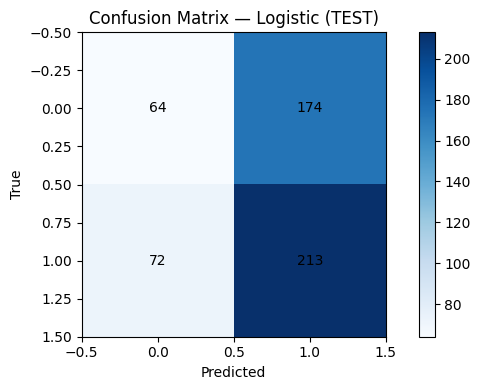

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


logit_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(with_mean=True),
    LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        random_state=RANDOM_STATE,
        max_iter=1000
    )
)


logit_pipe.fit(X_train, y_cls_train.values)


y_pred_test  = logit_pipe.predict(X_test)
y_proba_test = logit_pipe.predict_proba(X_test)[:, 1]


m_logit = cls_metrics(y_cls_test.values, y_pred_test, y_proba_test)
print("Logistic classification metrics (TEST):")
m_logit

plot_confmat(
    y_cls_test.values, y_pred_test,
    "Confusion Matrix — Logistic (TEST)",
    FIG_DIR / "cm_logistic_test.png"
)



Linear regression metrics (TEST): {'mae': 0.012346820537973265, 'rmse': np.float64(0.018165122479858624)}


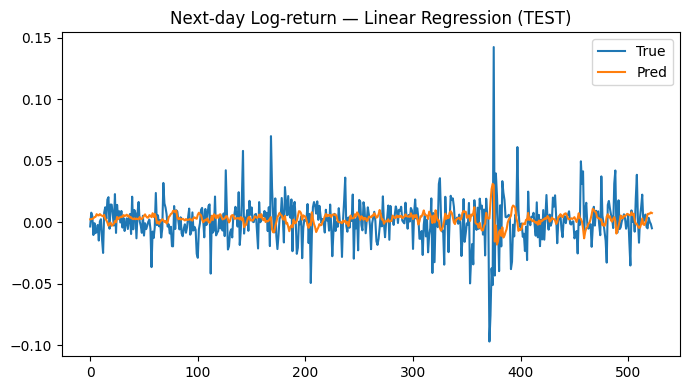

{'mae': 0.012346820537973265, 'rmse': np.float64(0.018165122479858624)}

In [ ]:


import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt


try:
    plot_pred_vs_true
except NameError:
    def plot_pred_vs_true(y_true, y_pred, title, path):
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(y_true, label="True", linewidth=1)
        ax.plot(y_pred, label="Pred", linewidth=1)
        ax.set_title(title, fontsize=14)
        ax.legend()
        fig.tight_layout()
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, dpi=150)
        plt.show()



X_train = np.where(np.isfinite(X_train), X_train, np.nan)
X_test  = np.where(np.isfinite(X_test),  X_test,  np.nan)


y_tr = y_reg_train.values
mask_tr = np.isfinite(y_tr)
X_tr = X_train[mask_tr]
y_tr = y_tr[mask_tr]

if X_tr.shape[0] == 0:
    print("No valid training data. Skipping regression.")
    m_linreg = {"mae": np.nan, "rmse": np.nan}

else:
    
    nan_cols = np.isnan(X_tr).all(axis=0)
    if nan_cols.any():
        X_tr[:, nan_cols] = 0.0
        X_test[:, nan_cols] = 0.0

    
    linreg_pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(with_mean=True),
        LinearRegression()
    )

    linreg_pipe.fit(X_tr, y_tr)

    
    y_pred_test_full = linreg_pipe.predict(X_test)

    y_te = y_reg_test.values
    mask_eval = np.isfinite(y_te)

    if mask_eval.sum() == 0:
        print(" No valid test target values.")
        m_linreg = {"mae": np.nan, "rmse": np.nan}

    else:
        y_te_eval   = y_te[mask_eval]
        y_pred_eval = y_pred_test_full[mask_eval]

        
        mae  = mean_absolute_error(y_te_eval, y_pred_eval)
        rmse = np.sqrt(mean_squared_error(y_te_eval, y_pred_eval))

        m_linreg = {"mae": mae, "rmse": rmse}
        print("Linear regression metrics (TEST):", m_linreg)

        
        plot_pred_vs_true(
            y_te_eval, y_pred_eval,
            "Next-day Log-return — Linear Regression (TEST)",
            FIG_DIR / "linreg_pred_vs_true_test.png"
        )

m_linreg


In [ ]:


import numpy as np, pandas as pd
from pathlib import Path

def _maybe(d, k):
    try:
        return d.get(k, np.nan)
    except Exception:
        return np.nan


if "m_naive" not in globals():  m_naive  = {}
if "m_logit" not in globals():  m_logit  = {}
if "m_linreg" not in globals(): m_linreg = {}

summary = pd.DataFrame([
    {
        "model": "Naive-Persistence",
        "accuracy": _maybe(m_naive, "accuracy"),
        "balanced_accuracy": _maybe(m_naive, "balanced_accuracy"),
        "precision_macro": _maybe(m_naive, "precision_macro"),
        "recall_macro": _maybe(m_naive, "recall_macro"),
        "f1_macro": _maybe(m_naive, "f1_macro"),
        "roc_auc": np.nan,
        "mae": np.nan,
        "rmse": np.nan,
    },
    {
        "model": "Logistic-Cls",
        "accuracy": _maybe(m_logit, "accuracy"),
        "balanced_accuracy": _maybe(m_logit, "balanced_accuracy"),
        "precision_macro": _maybe(m_logit, "precision_macro"),
        "recall_macro": _maybe(m_logit, "recall_macro"),
        "f1_macro": _maybe(m_logit, "f1_macro"),
        "roc_auc": _maybe(m_logit, "roc_auc"),
        "mae": np.nan,
        "rmse": np.nan,
    },
    {
        "model": "Linear-Reg",
        "accuracy": np.nan,
        "balanced_accuracy": np.nan,
        "precision_macro": np.nan,
        "recall_macro": np.nan,
        "f1_macro": np.nan,
        "roc_auc": np.nan,
        "mae": _maybe(m_linreg, "mae"),
        "rmse": _maybe(m_linreg, "rmse"),
    },
])

summary_path = Path("reports/metrics_baseline.csv")
summary_path.parent.mkdir(parents=True, exist_ok=True)
summary.to_csv(summary_path, index=False)
print("Saved metrics to:", summary_path.resolve())
summary


Saved metrics to: C:\Users\15173\Desktop\stock-ts-forecast\reports\metrics_baseline.csv


,model,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,roc_auc,mae,rmse
0,Naive-Persistence,0.520076,0.515996,0.516007,0.515996,0.516000,NaN,NaN,NaN
1,Logistic-Cls,0.529637,0.508138,0.510488,0.508138,0.488087,0.478653,NaN,NaN
2,Linear-Reg,NaN,NaN,NaN,NaN,NaN,NaN,0.012347,0.018165
